# **Preprocessing Pipeline**

In [1]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt

## **1. Synchronization of recorded audio files**

In [7]:
# Load and synchronize audio files
audio_pi1, sr1 = librosa.load(".ata/./Draw/output_2024-10-17_171402.158245.wav", sr=None)
print("Pi1 audio loaded.")

audio_pi2, sr2 = librosa.load("../Data/raw/Valentin2.wav", sr=None)
print("Pi2 audio loaded.")


# Load and synchronize anomalous audio files
Aaudio_pi1, sr1 = librosa.load("../Data/raw/pi1_Aaudio.wav", sr=None)
print("Pi1 Aaudio loaded.")

Aaudio_pi2, sr2 = librosa.load("../Data/raw/pi2_Aaudio.wav", sr=None)
print("Pi2 Aaudio loaded.")

Pi1 audio loaded.
Pi2 audio loaded.
Pi1 Aaudio loaded.
Pi2 Aaudio loaded.


In [8]:
# Ensure the sample rates match
if sr1 != sr2:
    raise ValueError("Sample rates of the two files do not match")

# Trim silence
print("Trimming silence from both audio files...")
audio_pi1, _ = librosa.effects.trim(audio_pi1)
audio_pi2, _ = librosa.effects.trim(audio_pi2)
Aaudio_pi1, _ = librosa.effects.trim(Aaudio_pi1)
Aaudio_pi2, _ = librosa.effects.trim(Aaudio_pi2)

# Synchronize normal audio files
print("Computing cross-correlation for normal recordings...")
correlation_normal = fftconvolve(audio_pi1, audio_pi2[::-1], mode='full')
lag_normal = np.argmax(correlation_normal) - len(audio_pi2)
print(f"Detected delay for normal recordings: {lag_normal / sr1} seconds")

# Align normal audio files based on the lag
print("Aligning normal audio files...")
if lag_normal > 0:
    aligned_pi1 = audio_pi1[lag_normal:]
    aligned_pi2 = audio_pi2
else:
    aligned_pi1 = audio_pi1
    aligned_pi2 = audio_pi2[-lag_normal:]

min_length_normal = min(len(aligned_pi1), len(aligned_pi2))
aligned_pi1 = aligned_pi1[:min_length_normal]
aligned_pi2 = aligned_pi2[:min_length_normal]

# Save aligned normal audio files
#sf.write("aligned_pi1.wav", aligned_pi1, sr1)
#sf.write("aligned_pi2.wav", aligned_pi2, sr1)

# Synchronize anomalous audio files
print("Computing cross-correlation for anomalous recordings...")
correlation_anomalous = fftconvolve(Aaudio_pi1, Aaudio_pi2[::-1], mode='full')
lag_anomalous = np.argmax(correlation_anomalous) - len(Aaudio_pi2)
print(f"Detected delay for anomalous recordings: {lag_anomalous / sr1} seconds")

# Align anomalous audio files based on the lag
print("Aligning anomalous audio files...")
if lag_anomalous > 0:
    aligned_Api1 = Aaudio_pi1[lag_anomalous:]
    aligned_Api2 = Aaudio_pi2
else:
    aligned_Api1 = Aaudio_pi1
    aligned_Api2 = Aaudio_pi2[-lag_anomalous:]

min_length_anomalous = min(len(aligned_Api1), len(aligned_Api2))
aligned_Api1 = aligned_Api1[:min_length_anomalous]
aligned_Api2 = aligned_Api2[:min_length_anomalous]

# Save aligned anomalous audio files
#sf.write("aligned_Api1.wav", aligned_Api1, sr1)
#sf.write("aligned_Api2.wav", aligned_Api2, sr1)

print("All processing and saving completed.")

Trimming silence from both audio files...
Computing cross-correlation for normal recordings...
Detected delay for normal recordings: -35.20156462585034 seconds
Aligning normal audio files...
Computing cross-correlation for anomalous recordings...
Detected delay for anomalous recordings: 40.390249433106575 seconds
Aligning anomalous audio files...
All processing and saving completed.


In [9]:
# Save the aligned normal audio files
print("Saving aligned normal audio files...")
sf.write("../Data/aligned/aligned_pi1.wav", aligned_pi1, sr1)
sf.write("../Data/aligned/aligned_pi2.wav", aligned_pi2, sr1)

# Save a stereo version of the aligned normal audio
combined_audio_normal = np.vstack((aligned_pi1, aligned_pi2))
sf.write("../Data/aligned/aligned_stereo_normal.wav", combined_audio_normal.T, sr1)

# Save the aligned anomalous audio files
print("Saving aligned anomalous audio files...")
sf.write("../Data/aligned/aligned_Api1.wav", aligned_Api1, sr1)
sf.write("../Data/aligned/aligned_Api2.wav", aligned_Api2, sr1)

# Save a stereo version of the aligned anomalous audio
combined_audio_anomalous = np.vstack((aligned_Api1, aligned_Api2))
sf.write("../Data/aligned/aligned_stereo_anomalous.wav", combined_audio_anomalous.T, sr1)

print("Processing and saving completed for all audio files.")

Saving aligned normal audio files...
Saving aligned anomalous audio files...
Processing and saving completed for all audio files.


## **2. Transformations (STFT & MEL)**

In [26]:
# Paths to your audio files in the aligned folder
audio_pi1_path = "../Data/aligned/aligned_pi1.wav"
audio_pi2_path = "../Data/aligned/aligned_pi2.wav"
audio_Api1_path = "../Data/aligned/aligned_Api1.wav"
audio_Api2_path = "../Data/aligned/aligned_Api2.wav"

# Load aligned audio files
aligned_pi1, sr1 = librosa.load(audio_pi1_path, sr=None)
print("Aligned Pi1 normal audio loaded.")

aligned_pi2, sr2 = librosa.load(audio_pi2_path, sr=None)
print("Aligned Pi2 normal audio loaded.")

aligned_Api1, sr3 = librosa.load(audio_Api1_path, sr=None)
print("Aligned Pi1 anomalous audio loaded.")

aligned_Api2, sr4 = librosa.load(audio_Api2_path, sr=None)
print("Aligned Pi2 anomalous audio loaded.")


Aligned Pi1 normal audio loaded.
Aligned Pi2 normal audio loaded.
Aligned Pi1 anomalous audio loaded.
Aligned Pi2 anomalous audio loaded.


In [28]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_pi1 = librosa.stft(aligned_pi1, n_fft=1024, hop_length=512)
stft_pi2 = librosa.stft(aligned_pi2, n_fft=1024, hop_length=512)
stft_Api1 = librosa.stft(aligned_Api1, n_fft=1024, hop_length=512)
stft_Api2 = librosa.stft(aligned_Api2, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [31]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_pi1 = librosa.feature.melspectrogram(S=np.abs(stft_pi1), sr=sr1, n_mels=128)
mel_pi2 = librosa.feature.melspectrogram(S=np.abs(stft_pi2), sr=sr2, n_mels=128)
mel_Api1 = librosa.feature.melspectrogram(S=np.abs(stft_Api1), sr=sr3, n_mels=128)
mel_Api2 = librosa.feature.melspectrogram(S=np.abs(stft_Api2), sr=sr4, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_pi1 = librosa.power_to_db(mel_pi1, ref=np.max)
mel_db_pi2 = librosa.power_to_db(mel_pi2, ref=np.max)
mel_db_Api1 = librosa.power_to_db(mel_Api1, ref=np.max)
mel_db_Api2 = librosa.power_to_db(mel_Api2, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_pi1 = (mel_db_pi1 - np.mean(mel_db_pi1)) / np.std(mel_db_pi1)
mel_db_pi2 = (mel_db_pi2 - np.mean(mel_db_pi2)) / np.std(mel_db_pi2)
mel_db_Api1 = (mel_db_Api1 - np.mean(mel_db_Api1)) / np.std(mel_db_Api1)
mel_db_Api2 = (mel_db_Api2 - np.mean(mel_db_Api2)) / np.std(mel_db_Api2)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_pi1.npy", mel_db_pi1)
np.save("../Data/mel/mel_db_pi2.npy", mel_db_pi2)
np.save("../Data/mel/mel_db_Api1.npy", mel_db_Api1)
np.save("../Data/mel/mel_db_Api2.npy", mel_db_Api2)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


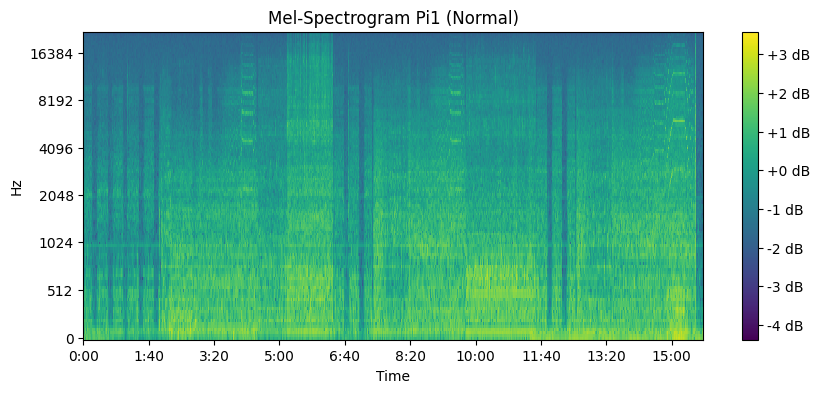

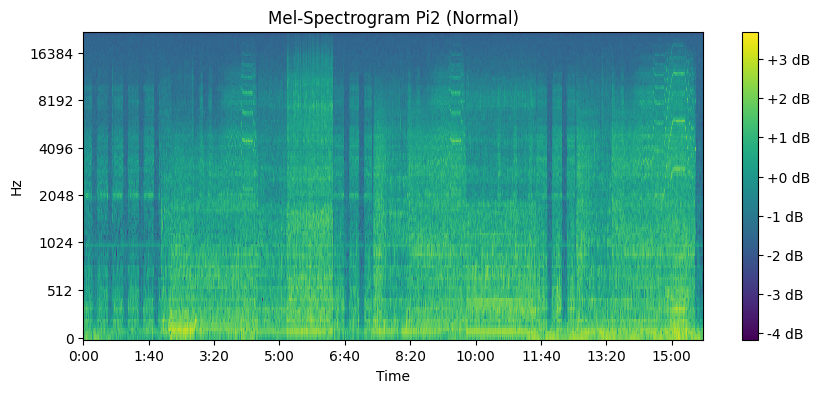

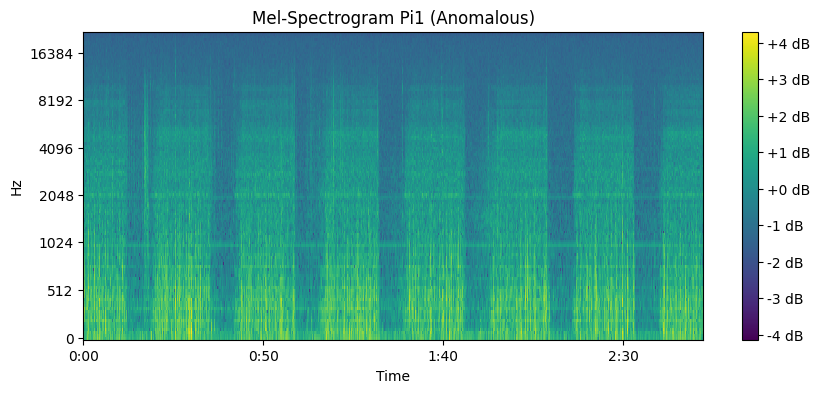

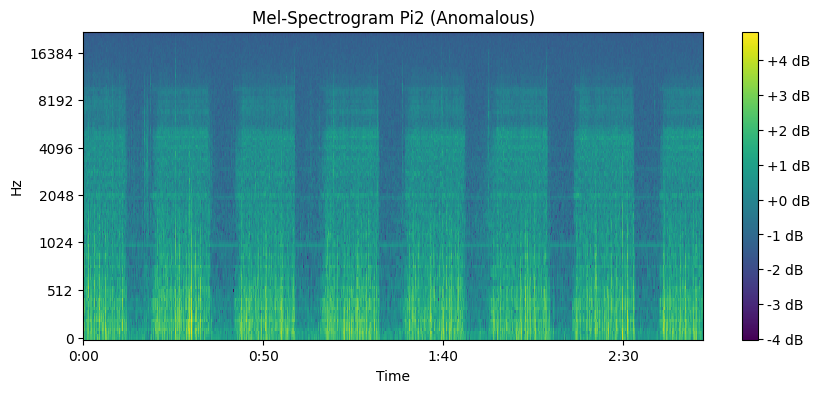

In [34]:
# Plot and save the Mel-spectrograms

# Normal Pi1
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi1 (Normal)')
plt.savefig('../Data/mel/mel_spectrogram_pi1.png')
plt.show()

# Normal Pi2
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi2 (Normal)')
plt.savefig('../Data/mel/mel_spectrogram_pi2.png')
plt.show()

# Anomalous Pi1
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_Api1, sr=sr3, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi1 (Anomalous)')
plt.savefig('../Data/mel/mel_spectrogram_Api1.png')
plt.show()

# Anomalous Pi2
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_Api2, sr=sr4, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi2 (Anomalous)')
plt.savefig('../Data/mel/mel_spectrogram_Api2.png')
plt.show()

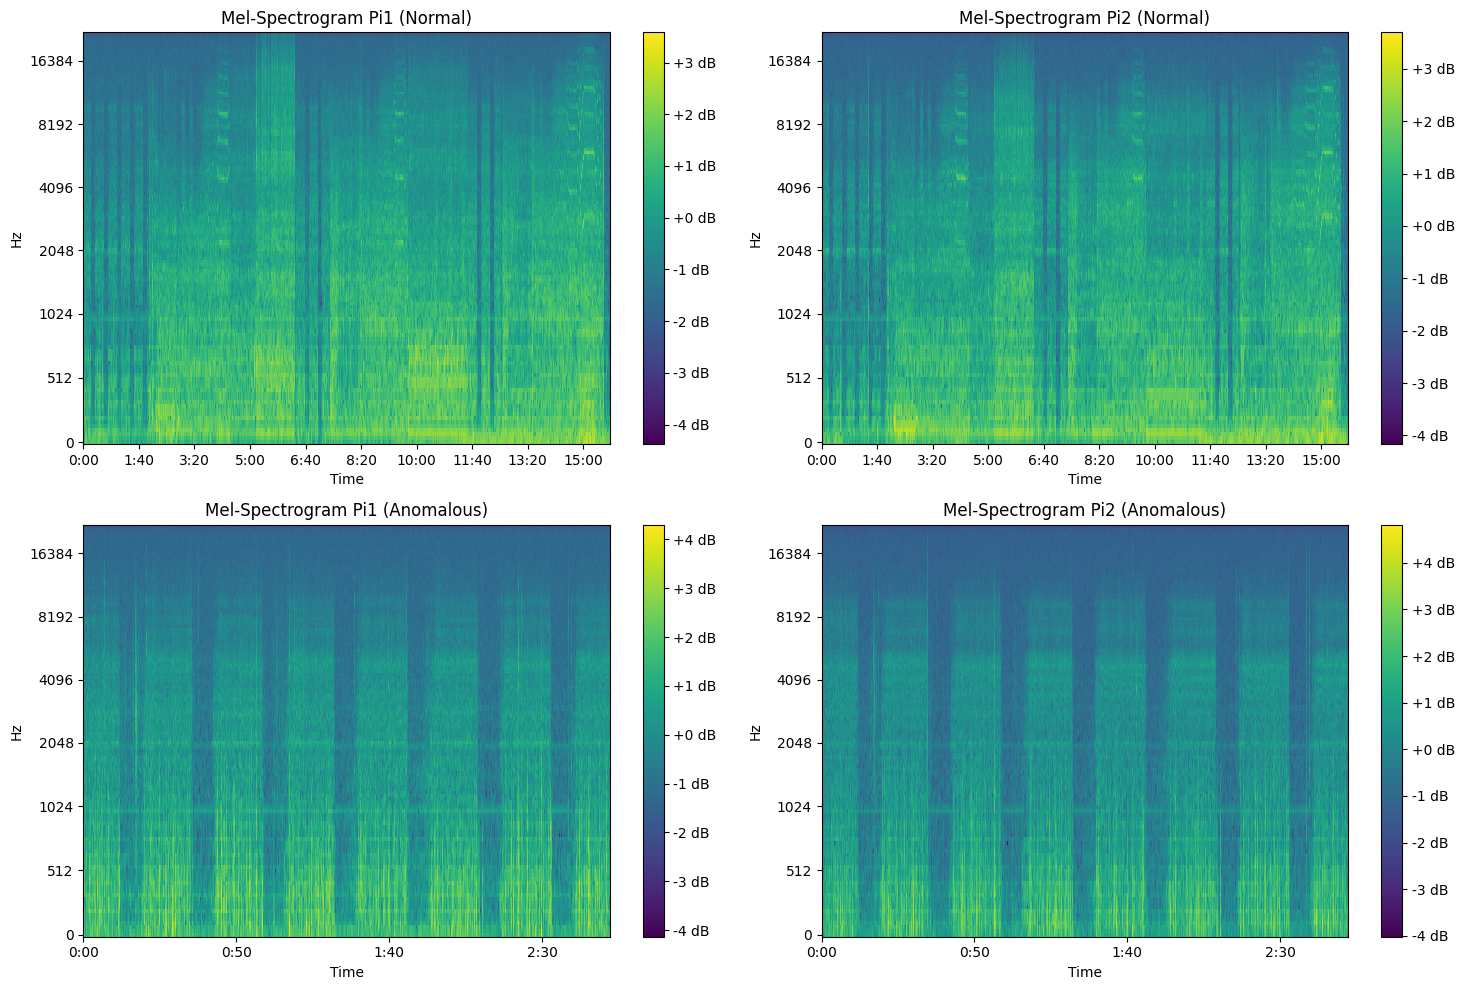

In [35]:
# Create a figure for the subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 0])
axs[0, 0].set(title='Mel-Spectrogram Pi1 (Normal)')
fig.colorbar(img1, ax=axs[0, 0], format='%+2.0f dB')

# Plot Normal Pi2
img2 = librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 1])
axs[0, 1].set(title='Mel-Spectrogram Pi2 (Normal)')
fig.colorbar(img2, ax=axs[0, 1], format='%+2.0f dB')

# Plot Anomalous Pi1
img3 = librosa.display.specshow(mel_db_Api1, sr=sr3, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 0])
axs[1, 0].set(title='Mel-Spectrogram Pi1 (Anomalous)')
fig.colorbar(img3, ax=axs[1, 0], format='%+2.0f dB')

# Plot Anomalous Pi2
img4 = librosa.display.specshow(mel_db_Api2, sr=sr4, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 1])
axs[1, 1].set(title='Mel-Spectrogram Pi2 (Anomalous)')
fig.colorbar(img4, ax=axs[1, 1], format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrograms_comparison.png')
plt.show()

## **3. Frame Generation**

In [36]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]

    return frames

# Generate frames for normal Pi1 and Pi2
frames_pi1 = generate_frames(mel_db_pi1)
frames_pi2 = generate_frames(mel_db_pi2)

# Generate frames for anomalous Pi1 and Pi2
frames_Api1 = generate_frames(mel_db_Api1)
frames_Api2 = generate_frames(mel_db_Api2)

print(f"Frames Pi1 (Normal): {frames_pi1.shape}")
print(f"Frames Pi2 (Normal): {frames_pi2.shape}")
print(f"Frames Api1 (Anomalous): {frames_Api1.shape}")
print(f"Frames Api2 (Anomalous): {frames_Api2.shape}")

Frames Pi1 (Normal): (1275, 128, 128)
Frames Pi2 (Normal): (1275, 128, 128)
Frames Api1 (Anomalous): (230, 128, 128)
Frames Api2 (Anomalous): (230, 128, 128)


# **Autoencoder**

## 4.1 Architecture

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # Latent space
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_shape[0] * input_shape[1]),
            nn.Sigmoid(),  # Sigmoid to ensure values are in the range [0,1]
            nn.Unflatten(1, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
input_shape = (frames_pi1.shape[1], frames_pi1.shape[2])  # Shape based on frames
autoencoder = Autoencoder(input_shape)

# Print model architecture
print(autoencoder)

Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=16384, bias=True)
    (3): Sigmoid()
    (4): Unflatten(dim=1, unflattened_size=(128, 128))
  )
)


## 4.2 Data preparation

In [38]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Split frames for Pi1
frames_pi1_train, frames_pi1_val = train_test_split(frames_pi1, test_size=0.2, random_state=42)
frames_pi2_train, frames_pi2_val = train_test_split(frames_pi2, test_size=0.2, random_state=42)

# Combine training sets from both Pi1 and Pi2
frames_train = np.concatenate((frames_pi1_train, frames_pi2_train), axis=0)
frames_val = np.concatenate((frames_pi1_val, frames_pi2_val), axis=0)

# Convert to PyTorch tensors
frames_train_tensor = torch.Tensor(frames_train)
frames_val_tensor = torch.Tensor(frames_val)

# Create DataLoaders for training and validation
train_dataset = TensorDataset(frames_train_tensor, frames_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(frames_val_tensor, frames_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 4.3 AE Training


In [39]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training the autoencoder
epochs = 50
for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = autoencoder(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}')

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")

Epoch 1/50, Training Loss: 0.7338, Validation Loss: 0.6172
Epoch 2/50, Training Loss: 0.6228, Validation Loss: 0.6026
Epoch 3/50, Training Loss: 0.6147, Validation Loss: 0.5983
Epoch 4/50, Training Loss: 0.6110, Validation Loss: 0.5958
Epoch 5/50, Training Loss: 0.6087, Validation Loss: 0.5945
Epoch 6/50, Training Loss: 0.6080, Validation Loss: 0.5938
Epoch 7/50, Training Loss: 0.6071, Validation Loss: 0.5929
Epoch 8/50, Training Loss: 0.6065, Validation Loss: 0.5923
Epoch 9/50, Training Loss: 0.6060, Validation Loss: 0.5918
Epoch 10/50, Training Loss: 0.6054, Validation Loss: 0.5913
Epoch 11/50, Training Loss: 0.6053, Validation Loss: 0.5908
Epoch 12/50, Training Loss: 0.6049, Validation Loss: 0.5904
Epoch 13/50, Training Loss: 0.6044, Validation Loss: 0.5901
Epoch 14/50, Training Loss: 0.6043, Validation Loss: 0.5897
Epoch 15/50, Training Loss: 0.6034, Validation Loss: 0.5895
Epoch 16/50, Training Loss: 0.6035, Validation Loss: 0.5894
Epoch 17/50, Training Loss: 0.6035, Validation Lo

## 4.4 AE Evaluation

In [40]:
# Evaluate on validation data to set a threshold for anomaly detection
autoencoder.eval()
with torch.no_grad():
    reconstructed_frames = autoencoder(frames_val_tensor)
    reconstruction_error = torch.mean(torch.abs(frames_val_tensor - reconstructed_frames), dim=(1, 2))

# Convert error to NumPy array for further processing
reconstruction_error = reconstruction_error.numpy()

# Define a threshold for anomaly detection (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

Anomaly detection threshold: 1.036519169807434


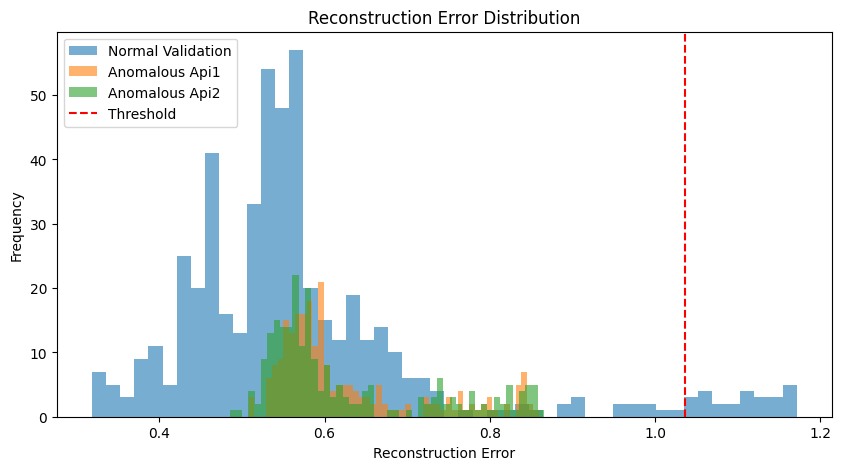

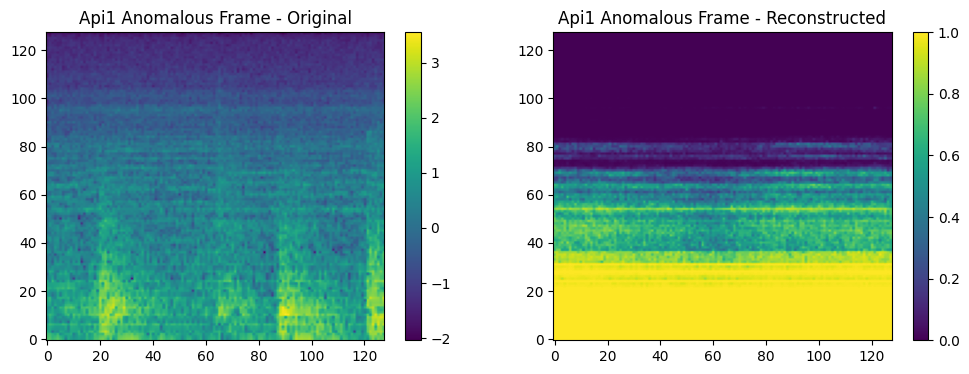

In [43]:
import matplotlib.pyplot as plt

# Plot reconstruction error distribution for normal validation set
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, alpha=0.6, label='Normal Validation')
plt.hist(test_reconstructed_error_Api1, bins=50, alpha=0.6, label='Anomalous Api1')
plt.hist(test_reconstructed_error_Api2, bins=50, alpha=0.6, label='Anomalous Api2')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize original and reconstructed frames for one anomalous frame
def plot_original_vs_reconstructed(original, reconstructed, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Original")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Reconstructed")
    plt.colorbar()
    plt.show()

# Example: Compare one anomalous frame from Api1
with torch.no_grad():
    frame_index = 0  # Adjust this index to view different frames
    original_frame = frames_Api1_tensor[frame_index].numpy()
    reconstructed_frame = test_reconstructed_Api1[frame_index].numpy()
    plot_original_vs_reconstructed(original_frame, reconstructed_frame, "Api1 Anomalous Frame")

## 4.5 Test AE

In [44]:
# Test on new data (Anomalous Pi1 and Pi2)
frames_Api1_tensor = torch.Tensor(frames_Api1)
frames_Api2_tensor = torch.Tensor(frames_Api2)

with torch.no_grad():
    test_reconstructed_Api1 = autoencoder(frames_Api1_tensor)
    test_reconstructed_error_Api1 = torch.mean(torch.abs(frames_Api1_tensor - test_reconstructed_Api1), dim=[1, 2])

    test_reconstructed_Api2 = autoencoder(frames_Api2_tensor)
    test_reconstructed_error_Api2 = torch.mean(torch.abs(frames_Api2_tensor - test_reconstructed_Api2), dim=[1, 2])

# Convert to NumPy
test_reconstructed_error_Api1 = test_reconstructed_error_Api1.numpy()
test_reconstructed_error_Api2 = test_reconstructed_error_Api2.numpy()

# Detect anomalies
anomalies_Api1 = test_reconstructed_error_Api1 > threshold
anomalies_Api2 = test_reconstructed_error_Api2 > threshold

print(f"Number of anomalies detected in Api1: {np.sum(anomalies_Api1)}")
print(f"Number of anomalies detected in Api2: {np.sum(anomalies_Api2)}")

Number of anomalies detected in Api1: 0
Number of anomalies detected in Api2: 0


## 4.6 Save Model and Results

In [42]:
# Save the trained model
torch.save(autoencoder.state_dict(), 'trained_autoencoder.pth')

# Save reconstruction errors
np.save('reconstruction_errors_Api1.npy', test_reconstructed_error_Api1)
np.save('reconstruction_errors_Api2.npy', test_reconstructed_error_Api2)

## Next Steps:
- Treshold tuning + test data
- Real-time deplyoment: integrate model into real-time system to analyze live data